# Background and notes:
"Electricity demand patterns matter for valuing electricity supply resources" http://www.eia.gov/todayinenergy/detail.cfm?id=12711
"Case study of daily electricity demand in New England" (shows hourly curve): http://www.eia.gov/todayinenergy/detail.cfm?id=830
hourly_jan01 = requests.get("https://webservices.iso-ne.com/api/v1.1/combinedhourlydemand/day/20140101/location/4008.json", auth=('travisknop@gmail.com', 'Nirvana1'))
Hourly day electricity demand: http://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/demand-by-zone
NOAA data: http://www7.ncdc.noaa.gov/CDO/cdoselect.cmd
Nat gas pipelines: http://www.eia.gov/pub/oil_gas/natural_gas/analysis_publications/ngpipeline/northeast.html
Common ISO-NE Abbrevs
drtp = demand response threshhold price
lmp = Locational Marginal Pricing

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy
import sklearn
import itertools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.cross_validation import train_test_split
%matplotlib inline

## Energy Sources

In [2]:
def load_energy_source():
    energy_source = pd.read_csv("~/travis_python/homework/FINAL/2014_energy_peak_source.csv", header=1)
    energy_source = energy_source.drop(energy_source.columns[14:], axis=1)
    energy_source = energy_source.drop(energy_source.index[:22])
    energy_source = energy_source.set_index("2014")
    energy_source = energy_source.applymap(int)
    energy_source["annual_pct"] = energy_source.Date / 108357
    energy_source.loc["Hydro"] = (energy_source.loc["Hydro:RunRiver&Pondage"] + energy_source.loc["Hydro:Pump Storage"])
    energy_source = energy_source.drop(energy_source.index[-2])
    energy_source = energy_source.drop(energy_source.index[11])
    energy_source = energy_source.drop(energy_source.index[8])
    energy_source = energy_source.drop(energy_source.index[6])
    energy_source = energy_source.drop(energy_source.index[5])
    energy_source = energy_source.sort(columns="annual_pct", ascending=False)
    print(energy_source.index)
    return energy_source

energy_source = load_energy_source()
energy_source

Index(['Total Generation (GWh)', 'Gas', 'Nuclear', 'Hydro', 'Coal', 'Oil/Gas',
       'Wood/Refuse', 'Refuse', 'Wind', 'Oil', 'Landfill Gas', 'Solar',
       'Steam', 'Methane/Refuse'],
      dtype='object', name='2014')


,Date,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,annual_pct
2014,,,,,,,,,,,,,,
Total Generation (GWh),108357,10095,8345,9051,8013,8435,9322,11085,10081,8927,8302,8031,8671,1.000000
Gas,42745,2472,2342,2362,3560,3588,4265,5354,4861,4037,3805,2985,3115,0.394483
Nuclear,36838,3440,3070,3454,2058,2718,3240,3336,3344,3297,2797,2766,3319,0.339969
Hydro,8708,846,614,595,928,1074,723,774,674,411,547,612,911,0.080364
Coal,5055,1067,1161,1239,352,21,42,231,41,62,4,548,286,0.046651
Oil/Gas,4839,952,369,371,379,308,299,607,389,367,316,254,230,0.044658
Wood/Refuse,3965,351,300,351,282,281,320,348,336,315,350,364,366,0.036592
Refuse,2577,213,188,234,186,221,225,218,225,216,222,221,209,0.023782
Wind,1929,211,177,204,190,137,114,114,90,135,185,212,160,0.017802


# Daily Weather Data~~~~~~~~

In [3]:
def to_fahrenheit(temp):
    return (temp * (9 / 5) + 32).round(1)

def load_weather_data():
    weather1 = pd.read_csv("/Users/travisknop/travis_python/homework/FINAL/weather_daily_2011_15.csv")
    weather1 = weather1.drop(weather1.columns[21], axis=1)
    weather1 = weather1.drop(weather1.columns[10:21], axis=1)
    weather1 = weather1.drop(weather1.columns[5:9], axis=1)
    weather1 = weather1.drop(weather1.columns[1], axis=1)
    weather1["Unnamed: 0"] = pd.to_datetime(weather1["Unnamed: 0"])
    weather1.columns = ["date", "highT", "avgT", "lowT", "avgH"]
    weather1 = weather1[pd.notnull(weather1['date'])]
    weather1 = weather1.set_index("date")
    weather1 = weather1.applymap(int)
    weather1["highT"] = weather1['highT'].apply(to_fahrenheit)
    weather1["avgT"] = weather1['avgT'].apply(to_fahrenheit)
    weather1["lowT"] = weather1['lowT'].apply(to_fahrenheit)
    weather1["hdd"] = weather1['avgT'].apply(lambda x: 65-x)
    return weather1

daily_weather = load_weather_data()
daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1802 entries, 2011-01-01 to 2015-12-07
Data columns (total 5 columns):
highT    1802 non-null float64
avgT     1802 non-null float64
lowT     1802 non-null float64
avgH     1802 non-null int64
hdd      1802 non-null float64
dtypes: float64(4), int64(1)
memory usage: 84.5 KB


In [4]:
daily_weather.to_csv("weather_daily_clean.csv")

([<matplotlib.patches.Wedge at 0x109e28ac8>,
  <matplotlib.text.Text at 0x109e576d8>])

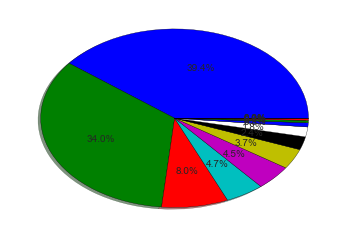

In [5]:
plt.pie(energy_source.Date[1:], autopct='%1.1f%%', shadow=True)

In [6]:
energy_source.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Total Generation (GWh) to Methane/Refuse
Data columns (total 14 columns):
Date          14 non-null float64
JAN           14 non-null float64
FEB           14 non-null float64
MAR           14 non-null float64
APR           14 non-null float64
MAY           14 non-null float64
JUN           14 non-null float64
JUL           14 non-null float64
AUG           14 non-null float64
SEP           14 non-null float64
OCT           14 non-null float64
NOV           14 non-null float64
DEC           14 non-null float64
annual_pct    14 non-null float64
dtypes: float64(14)
memory usage: 1.6+ KB


# Hourly Electricity

In [7]:
def load_hourly_elec():
    hourlydemand14 = pd.read_csv("~/travis_python/homework/FINAL/Hr_Elec_2011_2015c.csv")
    hourlydemand14 = hourlydemand14.convert_objects(convert_dates='coerce',convert_numeric=True)
    hourlydemand14 = hourlydemand14.drop(hourlydemand14.columns[0], axis=1)
    hourlydemand14 = hourlydemand14.drop(hourlydemand14.columns[1], axis=1)
    hourlydemand14 = hourlydemand14.dropna()
    return hourlydemand14
    

hr_elec = load_hourly_elec()
hr_elec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43248 entries, 0 to 43290
Data columns (total 3 columns):
Date     43248 non-null datetime64[ns]
MWH      43248 non-null float64
MWH.1    43248 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


# Daily Electricity

In [8]:
def convert_elec_hourly_to_daily():
    daily_energy = hr_elec.groupby("Date").aggregate(np.sum)
    daily_energy.to_csv("daily electric fixed")
    return daily_energy
    
dy_elec = convert_elec_hourly_to_daily()
dy_elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1801 entries, 2011-01-01 to 2015-12-06
Data columns (total 2 columns):
MWH      1801 non-null float64
MWH.1    1801 non-null float64
dtypes: float64(2)
memory usage: 42.2 KB


# Join Daily Weather and Electricity:

In [9]:
def join_daily_weather_and_elec():
    output = daily_weather.merge(dy_elec, left_index=True, right_index=True)
    return output
    
dy_w_elec = join_daily_weather_and_elec()
dy_w_elec.head()

,highT,avgT,lowT,avgH,hdd,MWH,MWH.1
2011-01-01,55.4,46.4,35.6,73,18.6,64323.3,61887.1
2011-01-02,51.8,44.6,37.4,85,20.4,64387.1,62618.6
2011-01-03,37.4,33.8,28.4,48,31.2,72881.9,73045.0
2011-01-04,39.2,32.0,24.8,52,33.0,73978.3,75228.5
2011-01-05,39.2,33.8,28.4,49,31.2,73338.9,74949.4


# Season & Climate

In [10]:
def load_climate():
    output = pd.read_csv("~/travis_python/homework/FINAL/Climate.csv")
    output = output.drop(output.columns[0], axis=1)
    output = output.iloc[:1801]
    output = output.set_index(dy_w_elec.index)
    return output

climate = load_climate()
climate.head()

,day_of_year,clim_high,clim_avg,clim_low
2011-01-01,0,37.8,30.7,23.6
2011-01-02,1,37.6,30.5,23.4
2011-01-03,2,37.5,30.4,23.3
2011-01-04,3,37.3,30.2,23.1
2011-01-05,4,37.2,30.1,22.9


# Add Climate to Daily

In [11]:
def add_climate_daily():
    df = dy_w_elec.merge(climate, left_index=True, right_index=True)
    return df

dwc_elec = add_climate_daily()
dwc_elec.head()


,highT,avgT,lowT,avgH,hdd,MWH,MWH.1,day_of_year,clim_high,clim_avg,clim_low
2011-01-01,55.4,46.4,35.6,73,18.6,64323.3,61887.1,0,37.8,30.7,23.6
2011-01-02,51.8,44.6,37.4,85,20.4,64387.1,62618.6,1,37.6,30.5,23.4
2011-01-03,37.4,33.8,28.4,48,31.2,72881.9,73045.0,2,37.5,30.4,23.3
2011-01-04,39.2,32.0,24.8,52,33.0,73978.3,75228.5,3,37.3,30.2,23.1
2011-01-05,39.2,33.8,28.4,49,31.2,73338.9,74949.4,4,37.2,30.1,22.9


# Regressions

In [12]:
daily_train = dwc_elec.iloc[:1795]
daily_test = dwc_elec.iloc[1795:]

In [13]:
def reshape_data(vector):
    reshaped_data = vector.values.reshape((-1, 1))
    return reshaped_data

def arrayed_data(vector):
    output = np.asarray(vector)
    return output

dayT = reshape_data(dwc_elec.avgT)
trainT = reshape_data(daily_train.avgT)
testT = reshape_data(daily_test.avgT)
daMWH = reshape_data(dwc_elec.MWH)
dayMWH = arrayed_data(dwc_elec["MWH.1"])
trainMWH = arrayed_data(daily_train["MWH.1"])
testMWH = arrayed_data(daily_test["MWH.1"])

## Combining Day of Year and Average Temp

In [14]:
day_temp = daily_train.loc[:, ["day_of_year", "avgT", "MWH"]]
dv = day_temp[["day_of_year", "avgT"]]
iv = day_temp["MWH"]
model2 = Pipeline([('poly', PolynomialFeatures(degree=6)),
                  ('linear', LinearRegression(fit_intercept=False))])
model2.fit(dv, iv)


/Users/travisknop/travis_python/.direnv/python-3.5.0/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/travisknop/travis_python/.direnv/python-3.5.0/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/travisknop/travis_python/.direnv/python-3.5.0/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


Pipeline(steps=[('poly', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

### Comparing Day Ahead to Real-Time

Variance Score: 0.92


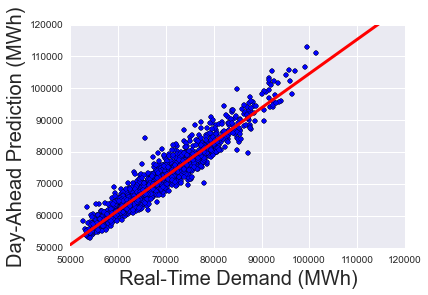

In [15]:
dart = Pipeline([('linear', LinearRegression(fit_intercept=True))])
dart.fit(daMWH, dayMWH)

print('Variance Score: %.2f' % dart.score(daMWH, dayMWH))

plt.scatter(daily_train.MWH, daily_train["MWH.1"])
def plot_regr(fn):
    # scatter plot first
    plt.scatter(dwc_elec["MWH"], dwc_elec["MWH.1"])
    xmin, xmax = plt.xlim(xmin=50000, xmax = 120000)
    xs = np.linspace(xmin, xmax, 100)
    # fn is our (y = mx + b) expression
    plt.ylabel("Day-Ahead Prediction (MWh)", size=20)
    plt.xlabel("Real-Time Demand (MWh)", size=20)
    plt.ylim(ymax=120000, ymin=50000)
    plt.plot(xs, [fn(x) for x in xs], color="red", linewidth=3)
    
fn = lambda x: dart.predict(x)[0]
plot_regr(fn)

In [16]:
def plot_regression(fn):
    # scatter plot first
    plt.figure(figsize=(20, 10))
    plt.scatter(dwc_elec.avgT, dwc_elec["MWH.1"])
    xmin, xmax = plt.xlim(xmin=0, xmax = 100)
    xs = np.linspace(xmin, xmax, 100)
    # fn is our (y = mx + b) expression
    plt.ylabel("Energy Load in Boston (MWh)", size=20)
    plt.xlabel("Temperature (°F)", size=20)
    plt.ylim(ymax=120000, ymin=40000)
    plt.plot(xs, [fn(x) for x in xs], color="red", linewidth=3)

Variance Score: 0.73


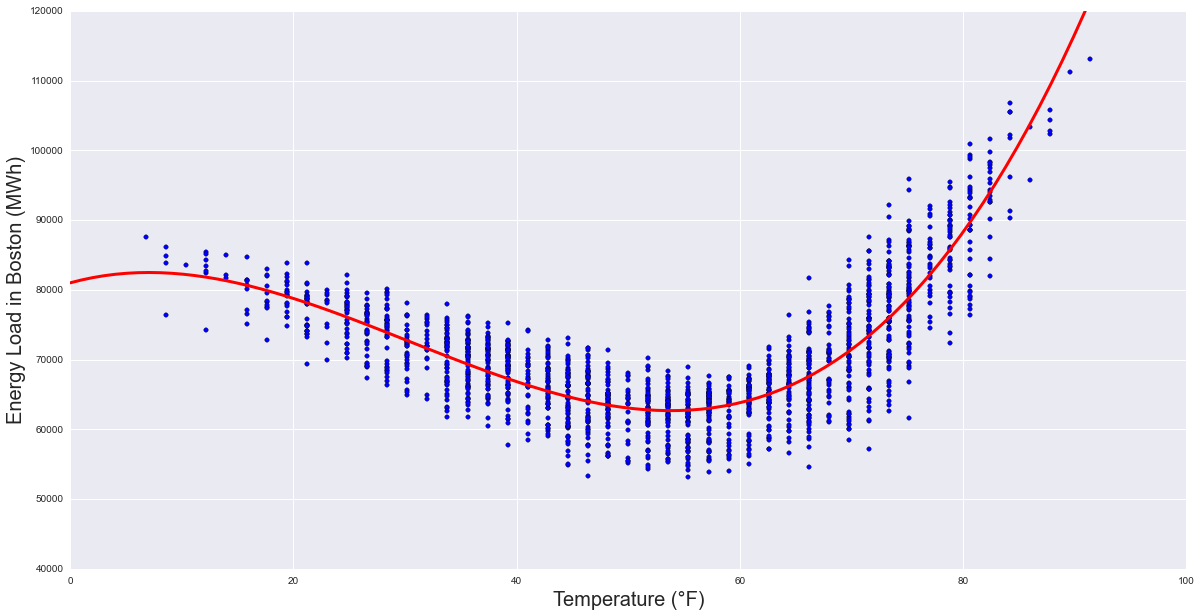

In [17]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(dayT, dayMWH)

print('Variance Score: %.2f' % model.score(dayT, dayMWH))

fn = lambda x: model.predict(x)[0]
plot_regression(fn)

In [24]:
daily_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2015-12-01 to 2015-12-06
Data columns (total 11 columns):
highT          6 non-null float64
avgT           6 non-null float64
lowT           6 non-null float64
avgH           6 non-null int64
hdd            6 non-null float64
MWH            6 non-null float64
MWH.1          6 non-null float64
day_of_year    6 non-null int64
clim_high      6 non-null float64
clim_avg       6 non-null float64
clim_low       6 non-null float64
dtypes: float64(9), int64(2)
memory usage: 576.0 bytes


# Predictions

In [28]:
st_forecast = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])
st_forecast.fit(trainT, trainMWH)
def plot_forecast(fn):
    # scatter plot first
    plt.figure(figsize=(20, 10))
    xs = np.linspace(xmin, xmax, 100)
    # fn is our (y = mx + b) expression
    plt.ylabel("Energy Load in Boston (MWh)", size=20)
    plt.xlabel("Temperature (°F)", size=20)
    plt.ylim(ymax=120000, ymin=40000)
    plt.plot(xs, [fn(x) for x in xs], color="red", linewidth=3)
    
fn = lambda x: model.predict(x)[0]
plot_forecast(fn)

NameError: name 'xmin' is not defined

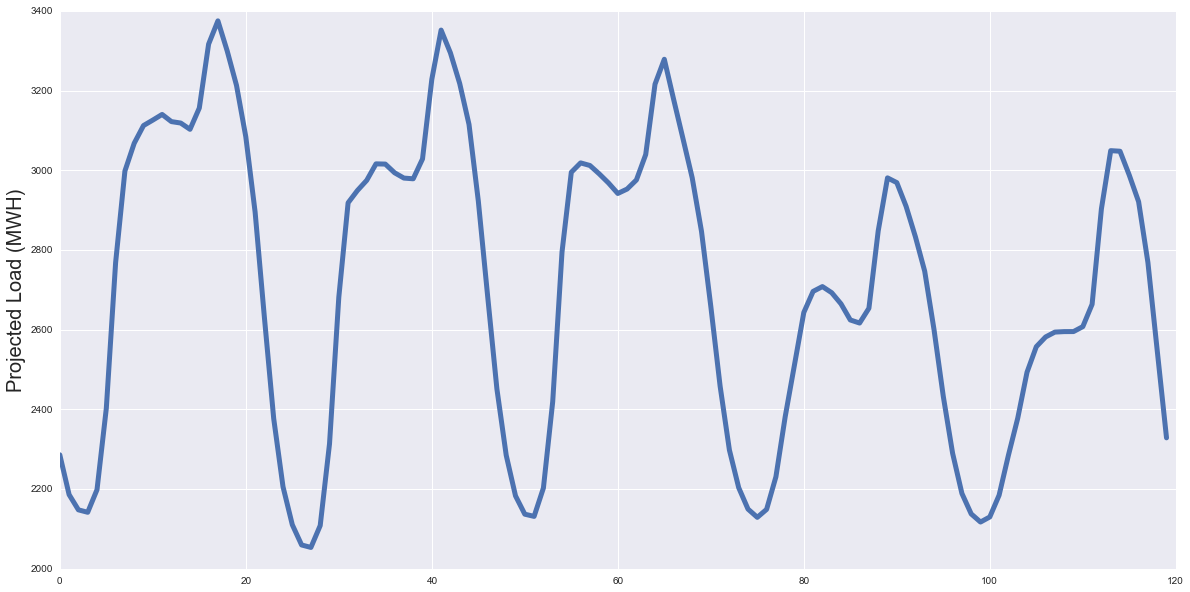

In [29]:
testhourly = hr_elec.iloc[-120:]
plt.figure(figsize=(20, 10))
plt.plot(testhourly["MWH.1"], linewidth=5)
plt.ylabel("Projected Load (MWH)", size=20)

In [ ]:
forecast = pd.read_csv("forecast.csv")
forecast.BeginDate = pd.to_datetime(forecast.BeginDate)

Variance Score: 0.73


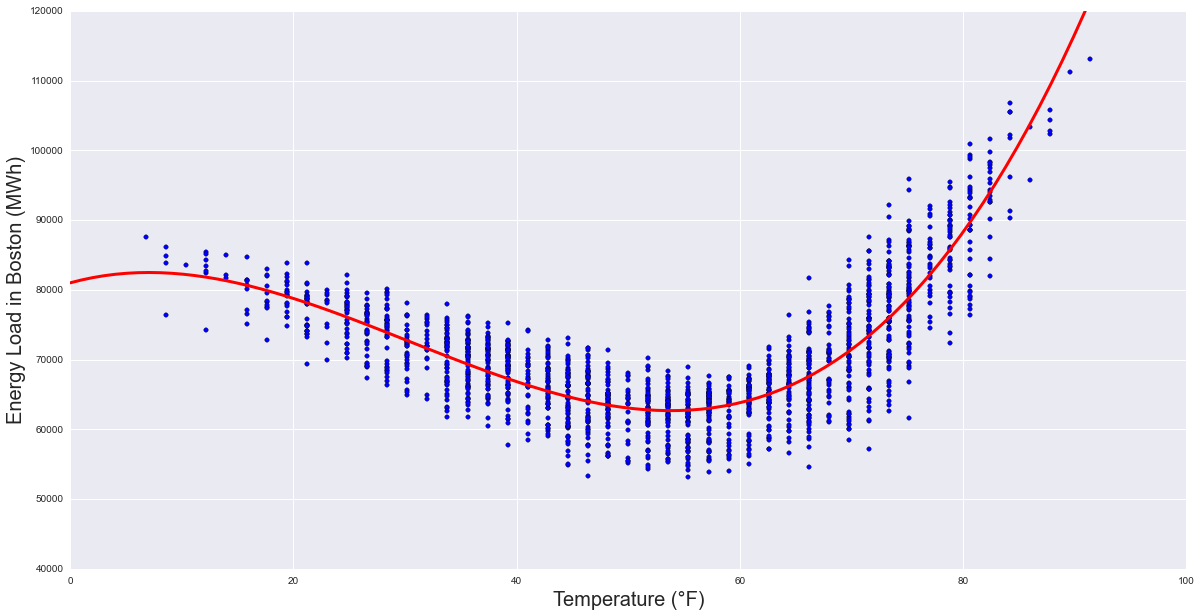

In [30]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(dayT, dayMWH)

print('Variance Score: %.2f' % model.score(dayT, dayMWH))

fn = lambda x: model.predict(x)[0]
plot_regression(fn)

# Locational Marginal Pricing

In [241]:
def load_lmp():
    lmp = pd.read_csv("/Users/travisknop/Downloads/da_rt_lmp_4008_20150101_20150214.csv", header=6)
    lmp = lmp.convert_objects(convert_numeric=True)
    lmp = lmp.dropna(axis=0, thresh=3)
    return lmp

lmp = load_lmp()
lmp.tail()

,H,Date,Hour Ending,Location ID,Location Name,Location Type,Locational Marginal Price,Energy Component,Congestion Component,Marginal Loss Component,Locational Marginal Price.1,Energy Component.1,Congestion Component.1,Marginal Loss Component.1
1076,D,02/14/2015,20,4008,.Z.NEMASSBOST,LOAD ZONE,154.65,152.63,0,2.02,186.29,182.46,0,3.83
1077,D,02/14/2015,21,4008,.Z.NEMASSBOST,LOAD ZONE,154.33,152.40,0,1.93,195.78,192.29,0,3.49
1078,D,02/14/2015,22,4008,.Z.NEMASSBOST,LOAD ZONE,149.12,147.11,0,2.01,198.50,194.96,0,3.54
1079,D,02/14/2015,23,4008,.Z.NEMASSBOST,LOAD ZONE,133.93,132.15,0,1.78,154.84,152.12,0,2.72
1080,D,02/14/2015,24,4008,.Z.NEMASSBOST,LOAD ZONE,126.70,125.10,0,1.60,134.86,132.63,0,2.23


In [ ]:
def arrayed_data(x):
    output = np.asarray(x)
    return output

lmp1 = arrayed_data(lmp["Locational Marginal Price.1"])
lmp2 = arrayed_data(lmp["Locational Marginal Price"])


In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(lmp2, dem3)
plt.ylabel("Projected Load (MW)", size=40)
plt.xlabel("Time", size=40)
plt.title("Four Day Load Forecast", size=60)

In [ ]:
len(lmp1)

In [ ]:
dem = hr_elec.set_index("Date")
dem2 = dem["MWH.1"][35100:36182]

In [ ]:
dem3 = arrayed_data(dem2)

# Natural Gas

In [ ]:
def load_gas():
    gas15 = pd.read_csv("ice_natgas-2015b.csv").iloc[:227]
    gas14 = pd.read_csv("ice_natgas-2014final.csv").iloc[:200]
    gas14['Daily volume MMBtu'] = gas14['Daily volume MMBtu'].str.replace(',', '')    
    gas = pd.concat([gas14, gas15])
    gas = gas.drop(gas.columns[10:], axis=1)
    gas = gas.drop(gas.columns[3:6], axis=1)
    gas = gas.drop(gas.columns[:2], axis=1)
    gas["Delivery start date"] = pd.to_datetime(gas["Delivery start date"])
    gas = gas.set_index("Delivery start date")
    gas = gas.applymap(float)
    return gas

gas = load_gas()
gas.info()


# Locational Marginal Price

In [243]:
lmp_list_of_files = [
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110101_20110214.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110215_20110331.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110401_20110515.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110516_20110629.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110630_20110813.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110814_20110927.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110928_20111110.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20111111_20111225.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20111226_20120208.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120209_20120324.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120325_20120508.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120509_20120622.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120623_20120806.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120807_20120920.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120921_20121104.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20121105_20121219.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20121220_20130202.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130203_20130319.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130320_20130503.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130504_20130617.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130618_20130801.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130802_20130915.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130916_20131030.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20131031_20131213.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20131214_20140127.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140128_20140313.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140314_20140427.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140428_20140611.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140612_20140726.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140727_20140909.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140910_20141024.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20141025_20141207.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20141208_20150121.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150101_20150131.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150122_20150307.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150308_20150421.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150422_20150605.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150606_20150720.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150721_20150903.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150904_20151018.csv"),
    pd.read_csv("~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20151019_20151201.csv"),
    ]

CParserError: Error tokenizing data. C error: Expected 2 fields in line 5, saw 10


In [ ]:
def load_lmp():
    list = []
    for file in lmp_list_of_files:
        list.append
    output = pd.concat(lmp_list_of_files)
    return output

lmp = load_lmp()
lmp.head()
        

In [255]:
lmp_list_of_files = [
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110101_20110214.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110215_20110331.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110401_20110515.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110516_20110629.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110630_20110813.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110814_20110927.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20110928_20111110.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20111111_20111225.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20111226_20120208.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120209_20120324.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120325_20120508.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120509_20120622.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120623_20120806.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120807_20120920.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20120921_20121104.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20121105_20121219.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20121220_20130202.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130203_20130319.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130320_20130503.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130504_20130617.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130618_20130801.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130802_20130915.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20130916_20131030.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20131031_20131213.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20131214_20140127.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140128_20140313.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140314_20140427.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140428_20140611.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140612_20140726.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140727_20140909.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20140910_20141024.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20141025_20141207.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20141208_20150121.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150101_20150131.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150122_20150307.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150308_20150421.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150422_20150605.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150606_20150720.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150721_20150903.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20150904_20151018.csv",
    "~/Downloads/New Folder With Items 2/lmp_rt_final_4008_20151019_20151201.csv",
    ]

In [256]:
lmp_df = []

for x in lmp_list_of_files:
    addon = pd.read_csv(x, header=6)
    pd.concat(lmp_df, addon)
    
lmp_df.head()

ValueError: All objects passed were None

# Looking for patterns...

In [43]:
dependent_vars = list(dwc_elec.columns)
#dependent_vars.remove('highT')
#dependent_vars.remove('avgT')
#dependent_vars.remove('lowT')
dependent_vars.remove('MWH')
dependent_vars.remove('MWH.1')
#dependent_vars.remove('clim_high')
#dependent_vars.remove('clim_avg')
#dependent_vars.remove('clim_low')
unos = list(itertools.combinations(dependent_vars, 1))
duos = list(itertools.combinations(dependent_vars, 2))
trios = list(itertools.combinations(dependent_vars, 3))
quadros = list(itertools.combinations(dependent_vars, 4))

In [55]:
choices = []

def regression_for(combo):
    combo = list(combo)
    df = day_elec.loc[:, combo + ['MWH.1']]
#    df.dropna(inplace=True)
    input_data = df[combo]
    demand = df['MWH.1']
    regra = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
    regra.fit(input_data, demand)
    return regra, regra.score(input_data, demand)

for combo in quadros:
    regra, score = regression_for(combo)
    choices.append((combo, score))
                   
best = sorted(choices, key=lambda x: x[1])[-1]
print(best)
regra, score = regression_for(best[0])
#print(regra.coef_, regra.intercept_)
print(choices)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
def pipe_x_degrees(x, dv, iv):
    for degree in range(x):
        model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])
        model.fit(dv, iv)
        print(model.score(dv, iv))

pipe_x_degrees(10, dayT, dayMWH)

In [ ]:
for combo in duos:
    regra, score = regression_for(combo)
    choices.append((combo, score))
                   
best = sorted(choices, key=lambda x: x[1])[-1]
print(best)
regra, score = regression_for(best[0])
print(regra.coef_, regra.intercept_)
print(choices)

In [ ]:
def pipe_it(dv, iv):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
    model.fit(dv, iv)
    print('Variance Score: %.2f' % model.score(dv, iv))
    
pipe_it(dayT, dayMWH)

In [46]:
dwc_elec["hdd_1_day_ago"] = dwc_elec.hdd.shift(1)
dwc_elec["hdd_2_days_ago"] = dwc_elec.hdd.shift(2)
dwc_elec["hdd_3_day_ago"] = dwc_elec.hdd.shift(3)
dwc_elec["hdd_tomorrow"] = dwc_elec.hdd.shift(-1)
dwc_elec["hdd_in_2_days"] = dwc_elec.hdd.shift(-2)
dwc_elec["hdd_in_3_days"] = dwc_elec.hdd.shift(-3)
dwc_elec["delta_t_since_yesterday"] = dwc_elec.hdd - dwc_elec["hdd_1_day_ago"]
dwc_elec["delta_t_tomorrow"] = dwc_elec["hdd_tomorrow"] - dwc_elec.hdd
dwc_elec["climate_deviation"] = dwc_elec.avgT - dwc_elec.clim_avg

In [54]:
day_elec = dwc_elec.dropna()
day_elec = day_elec.drop("highT", 1)
day_elec = day_elec.drop("avgT", 1)
day_elec = day_elec.drop("lowT", 1)
day_elec = day_elec.drop("clim_high", 1)
day_elec = day_elec.drop("clim_low", 1)
day_elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2011-01-04 to 2015-12-03
Data columns (total 15 columns):
avgH                       1795 non-null int64
hdd                        1795 non-null float64
MWH                        1795 non-null float64
MWH.1                      1795 non-null float64
day_of_year                1795 non-null int64
clim_avg                   1795 non-null float64
hdd_1_day_ago              1795 non-null float64
hdd_2_days_ago             1795 non-null float64
hdd_3_day_ago              1795 non-null float64
hdd_tomorrow               1795 non-null float64
hdd_in_2_days              1795 non-null float64
hdd_in_3_days              1795 non-null float64
delta_t_since_yesterday    1795 non-null float64
delta_t_tomorrow           1795 non-null float64
climate_deviation          1795 non-null float64
dtypes: float64(13), int64(2)
memory usage: 224.4 KB


,avgH,hdd,MWH,MWH.1,day_of_year,clim_avg,hdd_1_day_ago,hdd_2_days_ago,hdd_3_day_ago,hdd_tomorrow,hdd_in_2_days,hdd_in_3_days,delta_t_since_yesterday,delta_t_tomorrow,climate_deviation
2011-01-04,52,33.0,73978.3,75228.5,3,30.2,31.2,20.4,18.6,31.2,38.4,36.6,1.8,-1.8,1.8
2011-01-05,49,31.2,73338.9,74949.4,4,30.1,33.0,31.2,20.4,38.4,36.6,34.8,-1.8,7.2,3.7
2011-01-06,49,38.4,74143.1,76520.0,5,29.9,31.2,33.0,31.2,36.6,34.8,34.8,7.2,-1.8,-3.3
2011-01-07,71,36.6,73205.6,76217.1,6,29.8,38.4,31.2,33.0,34.8,34.8,36.6,-1.8,-1.8,-1.4
2011-01-08,85,34.8,67992.7,70957.2,7,29.6,36.6,38.4,31.2,34.8,36.6,38.4,-1.8,0.0,0.6


In [93]:
daytrain = day_elec.iloc[:1400]
daytest = day_elec.iloc[1400:]

In [231]:
dv2 = list(day_elec.columns)
dv2.remove('MWH')
dv2.remove('MWH.1')
unos = list(itertools.combinations(dv2, 1))
duos = list(itertools.combinations(dv2, 2))
trios = list(itertools.combinations(dv2, 3))
quadros = list(itertools.combinations(dv2, 4))
quintos = list(itertools.combinations(dv2, 5))
sixtos = list(itertools.combinations(dv2, 6))

In [234]:
choices = []

def regression_for(combo):
    combo = list(combo)
    df = day_elec.loc[:, combo + ['MWH.1']]
    df.dropna(inplace=True)
    input_data = df[combo]
#    print(input_data.head(), input_data.shape, type(input_data))
    demand = df['MWH.1']
#    print("")
#    print(demand.head(), demand.shape, type(demand))
    X_train, X_test, y_train, y_test = train_test_split(input_data, demand, random_state=1)
    regra = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])
    regra.fit(X_train, y_train)
#    if regra.score(X_train, y_train) > 0.7:
    y_pred = regra.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#    print("Hello", combo, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return regra, rmse

        
for combo in sixtos:
    regra, score = regression_for(combo)
    choices.append((combo, score))
                   
best = sorted(choices, key=lambda x: x[1])[0]
print("")
print(np.sqrt(metrics.mean_squared_error(day_elec["MWH"], day_elec["MWH.1"])))
print(best)
#regra, score = regression_for(best[0])
#print(choices)


3478.9616535
(('avgH', 'hdd', 'clim_avg', 'hdd_1_day_ago', 'delta_t_since_yesterday', 'climate_deviation'), 3822.2490965778043)


## Results:

#### Root Mean Squared Error, Day-Ahead vs Real-Time: 
3478.96

#### Root Mean Squared Error, Best Uno: 
4345.95 (hdd), 6 degree poly

#### Root Mean Squared Error, Best Duo: 
4010.29 (hdd_1_day_ago, delta_t_since_yesterday), 3 degree poly

#### Root Mean Squared Error, Best Trio: 
3760.529 (avgH, hdd, delta_t_since_yesterday'), 3 degree poly

#### Root Mean Squared Error, Best Quadro: 
3713.317 (avgH, clim_avg, hdd_1_day_ago, climate_deviation), 3 degree poly

#### Root Mean Squared Error, Best Quinto: 
(('avgH', 'hdd', 'day_of_year', 'clim_avg', 'delta_t_since_yesterday'), 3684.2998746559942),  3 degree poly


In [69]:
test_MWH = arrayed_data(daytest["MWH.1"])

In [82]:
print(daytrain.shape, daytest.shape, test_MWH.shape)

(1500, 15) (295, 15) (295,)


In [92]:
testdf = daytest
testdf['MWH.1']

2015-02-12    79528.8
2015-02-13    81212.6
2015-02-14    77787.4
2015-02-15    76332.7
2015-02-16    83806.0
2015-02-17    82094.1
2015-02-18    78046.7
2015-02-19    77676.0
2015-02-20    82666.1
2015-02-21    76803.5
2015-02-22    69258.2
2015-02-23    78054.3
2015-02-24    83591.4
2015-02-25    78247.7
2015-02-26    79735.2
2015-02-27    77966.5
2015-02-28    73672.3
2015-03-01    73220.5
2015-03-02    75439.3
2015-03-03    76213.2
2015-03-04    72650.0
2015-03-05    75010.1
2015-03-06    77323.0
2015-03-07    69780.3
2015-03-08    64179.6
2015-03-09    70384.8
2015-03-10    68841.9
2015-03-11    65839.6
2015-03-12    68149.9
2015-03-13    70120.7
               ...   
2015-11-04    62194.2
2015-11-05    64208.1
2015-11-06    65314.5
2015-11-07    56459.7
2015-11-08    55501.3
2015-11-09    62917.5
2015-11-10    63652.2
2015-11-11    63643.9
2015-11-12    64418.8
2015-11-13    62094.4
2015-11-14    59080.1
2015-11-15    58805.6
2015-11-16    63587.4
2015-11-17    65136.4
2015-11-18

In [210]:
def regression_for(combo):
    combo = list(combo)
    df = day_elec.loc[:, combo + ['MWH.1']]
    df.dropna(inplace=True)
    input_data = df[combo]
#    print(input_data.head(), input_data.shape, type(input_data))
    demand = df['MWH.1']
#    print("")
#    print(demand.head(), demand.shape, type(demand))
    X_train, X_test, y_train, y_test = train_test_split(input_data, demand, random_state=1)
    regra = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
    regra.fit(X_train, y_train)
#    if regra.score(X_train, y_train) > 0.7:
    y_pred = regra.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#    print("Hello", combo, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    output = y_test.to_frame()
    output["y_pred"] = y_pred
    return output

        
testcomp = regression_for(('avgH', 'hdd', 'day_of_year', 'clim_avg', 'delta_t_since_yesterday'))

In [211]:
testcomp

,MWH.1,y_pred
2015-12-01,70125.8,69365.262557
2011-10-24,66117.0,62089.490692
2014-11-05,64124.5,62639.051754
2015-01-15,77767.3,76400.827546
2012-04-29,56174.5,61508.109932
2013-04-11,64113.4,62628.230456
2014-02-25,76381.4,73489.158618
2013-10-26,60064.5,63139.828809
2014-08-13,74634.7,72843.365459
2011-06-30,77609.2,76630.516523


In [213]:
comparing = testcomp.join(day_elec.MWH, how="inner")

In [215]:
comparing.head()

,MWH.1,y_pred,MWH
2011-01-04,75228.5,72846.799081,73978.3
2011-01-07,76217.1,74974.157916,73205.6
2011-01-12,75023.5,73828.272709,75360.1
2011-01-23,76563.5,79519.767193,70148.0
2011-01-26,82056.6,78248.268269,74457.1


In [216]:
lr1 = LinearRegression()
lr1.fit(comparing.MWH.to_frame(), comparing["MWH.1"])
print('Day-Ahead Variance Score: %.4f' % lr1.score(comparing.MWH.to_frame(), comparing["MWH.1"]))


Day-Ahead Variance Score: 0.9152


In [218]:
lr2 = LinearRegression()
lr2.fit(comparing.y_pred.to_frame(), comparing["MWH.1"])
print('Predicted Variance Score: %.4f' % lr2.score(comparing.y_pred.to_frame(), comparing["MWH.1"]))

Predicted Variance Score: 0.8226


TypeError: 'numpy.ndarray' object is not callable